# Peeking

Problem:
https://www.evanmiller.org/how-not-to-run-an-ab-test.html

In order to visualize the increase in Type I error resulted from multiple peeks at the data, we will simulate 1000 A/A tests with predefined number of peeks. The tests will be stoped whenever the p-value is below our alpha threshold and the cumulative error is recorded.

In [1]:
%matplotlib inline

from pathlib import Path
import random
import decimal

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binom
#from scipy.stats import distributions as dist

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# Set seed for reproducibility
np.random.seed(4)

# Create DataFrame
df = pd.DataFrame(columns=('peek','n', 'A', 'B', 'statsig', 'effect'))

# Define testing parameters
n_tests = 1000
n_obs = 40000
conv_rate = 0.2
alpha = 0.05
n_peeks = 40

# Perform the first peek and record the testing results
for k in range(n_tests):

  # sample 2 times from the control binomial distribution
  n = n_obs/n_peeks
  tests = 2
  samples = np.random.binomial(n, conv_rate, tests)
  success_A, success_B = samples[0], samples[1]
  trials_A = trials_B = n

  # perform z-test for proportions
  count = np.array([success_B, success_A])
  nobs = np.array([trials_B, trials_A])
  z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

  # record the results
  statsig = 1 if p_value < alpha else 0
  effect = (success_B / success_A) -1 if p_value < alpha  else None
  peek = [1, trials_A, success_A, success_B, statsig, effect]
  df.loc[len(df)] = peek


# Perform the rest of the peekings and record the testing results
for j in range(n_peeks-1):
  for k in range(n_tests):
    # Followup weeks
    n = n_obs/n_peeks
    tests = 2
    samples = np.random.binomial(n, conv_rate, tests)
    success_A, success_B = samples[0], samples[1]
    trials_A = trials_B = n

    suc_A_peek_ant = df[df.peek == j+1]['A'].loc[(n_tests*j)+k]
    suc_B_peek_ant = df[df.peek == j+1]['B'].loc[(n_tests*j)+k]
    trials_ant = df[df.peek == j+1]['n'].loc[(n_tests*j)+k]
    statsig_ant = df[df.peek == j+1]['statsig'].loc[(n_tests*j)+k]

    success_A = success_A + suc_A_peek_ant
    success_B = success_B + suc_B_peek_ant
    trials_A = trials_ant + trials_A
    trials_B = trials_ant + trials_B

    # Significance testing
    count = np.array([success_B , success_A ])
    nobs = np.array([trials_B, trials_A])
    z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
    statsig = 1 if p_value < alpha else 0
    statsig = statsig + statsig_ant
    effect = (success_B / success_A) -1 if p_value < alpha  else None

    peek = [j+2, trials_A, success_A, success_B, statsig, effect]
    df.loc[len(df)] = peek

# Falso positvo por semana
df = df.assign(statsig_final=np.where(df.statsig > 0, 1, 0))
df_results = df.groupby('peek').agg({'statsig_final':'mean'})
df_results

,statsig_final
peek,
1.0,0.060
2.0,0.105
3.0,0.129
4.0,0.141
5.0,0.152
6.0,0.166
7.0,0.174
8.0,0.184
9.0,0.191


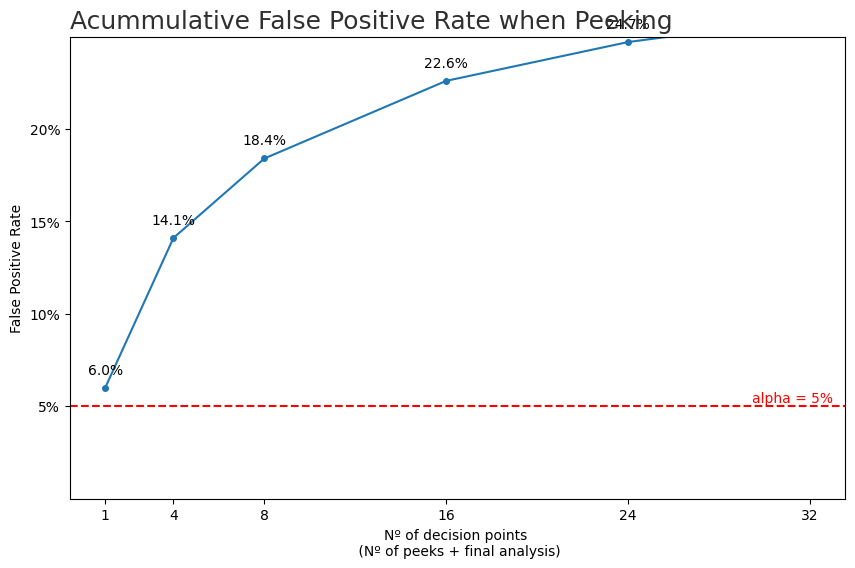

In [5]:
# Set plot size
plt.figure(figsize=(10,6))

# Select the number data to show on the plot
df_plot = df_results.query("peek in (1,4,8,16,24,32)").reset_index()

# Plot the line plot
plt.plot(df_plot['peek'],df_plot['statsig_final'], marker='o', markersize=4)

# Add a horizontal line at y=0.05
plt.axhline(y=0.05, color='r', linestyle='--')

# Add text 'alpha = 0.05' at y=0.05 to the right
plt.text(33, 0.052, 'alpha = 5%', color='red', horizontalalignment='right')

# Set the labels and title
plt.xlabel('Nº of decision points \n (Nº of peeks + final analysis)')
plt.ylabel('False Positive Rate')
plt.title(label='Acummulative False Positive Rate when Peeking',
          fontsize=18,
          color='#303030',
          loc='left')

# Format y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
plt.ylim(0.0, 0.25)
plt.yticks(ticks=[0.05,0.1, 0.15, 0.2])

# Set x-axis ticks to show only the numbers of peeks selected
plt.xticks(ticks=[1,4,8,16,24,32])


for x,y in zip(df_plot['peek'],df_plot['statsig_final']):

    label = "{:,.1%}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# Show the plot
plt.grid(False)
plt.show()
